# Neural ODEs
 - In this notebook we will train a neural differential equation to map images of each MNIST integer to the next one along
 - We will make use of the autoencoder style network used in the autoencoder workshop

In [2]:
import jax
import jax.numpy as np
import jax.random as jr
import optax
import equinox as eqx 
import einops
import diffrax 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

In [7]:
SEED = 1234
key = jr.PRNGKey(SEED) # JAX is very explicit with pseudo-random numbers, such that everything can be kept as a "pure" function when needed

## Data loading is a bit different now
- We need to sort our dataset by what the integers are
- Now the batch index selects what number the image represents

In [164]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,np.newaxis] / 255.0
x_test = x_test[:,np.newaxis] / 255.0

#x_train = x_train - einops.reduce(x_train,"B i x y -> B i () ()","mean")
#x_test = x_test - einops.reduce(x_test,"B i x y -> B i () ()","mean")


x_train_grouped = []
lengths = []
for i in range(10):
    x_train_grouped.append(x_train[y_train==i])
    lengths.append(x_train_grouped[i].shape[0])

minlength = np.min(np.array(lengths))
for i in range(10):
    x_train_grouped[i] = x_train_grouped[i][:minlength]
x_train_grouped = einops.rearrange(x_train_grouped,"numbers N b x y -> N (b numbers) () x y")
#print(x_train_grouped.shape)

X0 = x_train_grouped[:,0]
XT = x_train_grouped[:,1:]

print(X0.shape)
print(XT.shape)

(5421, 1, 28, 28)
(5421, 9, 1, 28, 28)


## Use the Autoencoder structure as the right hand side of the ODE:
- $\frac{dy}{dt} = F_\theta(t,y(t))$
- In general we can use any function of this form: $F_\theta:\mathbb{R}^{1\times N}\rightarrow\mathbb{R}^N$
- Generally for good performance with Neural ODEs, we want $F$ to depend on $t$
    - In this case we shall use a fully connected feedforward network on the time input and add this to the latent space in the autoencoder
- When using a `eqx.Module` derived class in a neural ODE, we need the `__call__` method be of the form `(t,y,args)->y`

In [138]:
class Autoencoder(eqx.Module):
    encode_layers: list
    decode_layers: list
    time_encode_layers: list
    def __init__(self, key,channels=1):
        key1, key2, key3, key4, key5, key6, key7,key8 = jax.random.split(key, 8)
        # Standard CNN autoencoder - consecutive layers get narrower via MaxPool2d, and the expanded out again via ConvTranspose2d
        # with a small MLP on top.
        self.encode_layers = [
            eqx.nn.Conv2d(channels, 8, kernel_size=6, key=key1),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.gelu,
            eqx.nn.Conv2d(8, 4, kernel_size=5, key=key2),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.gelu,
            eqx.nn.Conv2d(4, 4, kernel_size=4, key=key3),
            eqx.nn.MaxPool2d(kernel_size=4),
            jax.nn.gelu
        ]
        self.decode_layers = [
            eqx.nn.ConvTranspose2d(4,4,kernel_size=4,key=key4),
            jax.nn.gelu,
            eqx.nn.ConvTranspose2d(4,8,kernel_size=5,stride=2,key=key5),
            jax.nn.gelu,
            eqx.nn.ConvTranspose2d(8,channels,kernel_size=6,key=key6),
        ]
        self.time_encode_layers = [
            eqx.nn.Linear(1,100,key=key7),
            jax.nn.gelu,
            eqx.nn.Linear(100,196,key=key8),
            jax.nn.tanh,
            lambda x:einops.rearrange(x,"(k kw kh)-> k kw kh",kw=7,kh=7)
        ]

    def encode(self,x):
        for L in self.encode_layers:
            x = L(x)
        return x
    
    def decode(self,x):
        for L in self.decode_layers:
            x = L(x)
        return x
    
    def time_encode(self,t):
        for L in self.time_encode_layers:
            t = L(t)
        return t
    def __call__(self, t, y, args):
        y = self.encode(y)
        te = self.time_encode(np.array([t]))
        y = y + te
        y = self.decode(y)
        
        return y

## Define another `eqx.Module` subclass that solves an ODE
- In the `__call__` method here we have `diffrax.diffeqsolve(...)`
    - This uses a 5th order adaptive stepsize solver to much better approximate a continous ODE than euler's method (RNNs)
- This `ODE_solver` also just works like any other `eqx.Module` - i.e. works with `grad`, `vmap`, `jit`

In [139]:
class ODE_solver(eqx.Module):
    update: Autoencoder


    def __init__(self,key):
        self.update = Autoencoder(key)
        
    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.update),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-2, atol=1e-4),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

## Define the loss function
 - Here the `jax.vmap` is more subtle, as we want the same time input for all the different X inputs

In [142]:
@eqx.filter_value_and_grad
def loss(model,x0,xt):
    v_model= jax.vmap(lambda y0:model(ts=np.arange(9),y0=y0),in_axes=0,out_axes=0,axis_name="BATCH")
    xt_predicted = v_model(x0)
    
    return np.mean((xt-xt_predicted)**2)

## Define the train method
 - This is pretty standard now - iterate through random batch samples of `X0` and `XT`

In [143]:
def train(model,steps,LEARN_RATE=1e-2,BATCH_SIZE=32):
    schedule = optax.exponential_decay(LEARN_RATE, transition_steps=steps, decay_rate=0.98)
    optim = optax.adam(schedule)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    loss_log = []
    
    @eqx.filter_jit # Wrap this in a filter_jit to speed things up
    def make_step(model,opt_state,x0,xt):
        
        loss_value,grad = loss(model,x0,xt)
        updates, opt_state = optim.update(grad, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
   
    train_key = jr.fold_in(key,1)
    for i in tqdm(range(steps)):
        train_key = jr.fold_in(train_key,i)
        # Choose which samples from x_train to fit to this iteration
        inds = jr.choice(train_key,np.arange(5421),(BATCH_SIZE,),replace=False)
        x0 = X0[inds]
        xt = XT[inds]
        
        # Do the actual gradient update
        model, opt_state, train_loss = make_step(model, opt_state, x0,xt)
        loss_log.append(train_loss)
        if i%10==0:
            tqdm.write("Loss at step "+str(i)+": "+str(train_loss))
    
    return model,loss_log

In [165]:
node = ODE_solver(key)
model_trained,loss_log = train(node,20)

  0%|          | 0/20 [00:00<?, ?it/s]

Loss at step 0: 0.17896007
Loss at step 10: 0.16287099


In [158]:
XS = model_trained(np.linspace(0,9,100),X0[0])

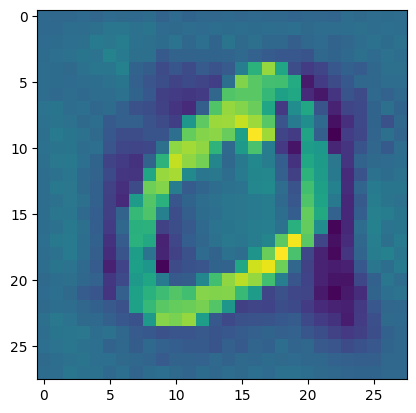

In [163]:
plt.imshow(XS[99,0])